<a href="https://www.kaggle.com/code/subhamshome/mwd-simple-cnn?scriptVersionId=140998866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import os
import re
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from skimage import io, color, transform
from skimage.transform import rotate, rescale, resize
from skimage.exposure import adjust_gamma, adjust_sigmoid
from skimage.color import rgb2hsv, hsv2rgb
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
# constants - folder, resizing factor, file extensions to be handled
image_folder = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
size_fact = 64
img_width, img_height, channels = size_fact, size_fact, 3
file_extensions = ['.jpg', '.jpeg'] # since some images were of type .jpeg

In [3]:
# create class labels and image counts
def count_images_in_subfolders(folder_path):
    class_labels = []
    image_counts = []

    if not os.path.exists(folder_path): # check for folder
        print("Folder does not exist.") 
        return class_labels, image_counts

    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    for subfolder in subfolders:
        # check for both .jpg and .jpeg since there are some .jpeg files as well
        jpg_count = len([filename for filename in os.listdir(os.path.join(folder_path, subfolder)) if filename.lower().endswith(('.jpg', '.jpeg'))])
        class_labels.append(subfolder)
        image_counts.append(jpg_count)

    return class_labels, image_counts

# run for image folder
classes, num_images_per_class = count_images_in_subfolders(image_folder)

print(classes)
print(num_images_per_class)

['Cloudy', 'Sunrise', 'Rain', 'Shine']
[300, 357, 215, 253]


In [4]:
# rearrange for better representation and following the input data order (this step is optional)
def list_rearrange(listname):
    second_item = listname.pop(1)
    listname.append(second_item)

list_rearrange(classes)
list_rearrange(num_images_per_class)

print(classes)
print(num_images_per_class)

['Cloudy', 'Rain', 'Shine', 'Sunrise']
[300, 215, 253, 357]


In [5]:
images = []
labels = []
def load_and_preprocess_images(folder_path, num_images_per_class, file_extensions=['.jpg', '.jpeg']):

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)

        for dirpath, dirnames, filenames in os.walk(class_folder):
            for i in tqdm(range(1, num_images_per_class[class_idx] + 1), desc=f'Loading {class_name} images'):
                for extension in file_extensions:
                    for filename in filenames:
                        if filename.startswith(f'{class_name.lower()}{i}') and filename.endswith(extension):
                            image_path = os.path.join(dirpath, filename)

                            image = io.imread(image_path)
                            
                            # conditional formatting
                            if image.shape[-1] == 4:
                                image = image[:, :, :3]
                            elif len(image.shape) == 2:
                                image = color.gray2rgb(image)
                            elif len(image.shape) == 4:
                                image = image[0]

                            image = transform.resize(image, (img_width, img_height))
                            images.append(image)
                            labels.append(class_idx)
                            
                            break

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(image_folder, num_images_per_class, file_extensions)

Loading Sunrise images: 100%|██████████| 357/357 [01:02<00:00,  5.74it/s]


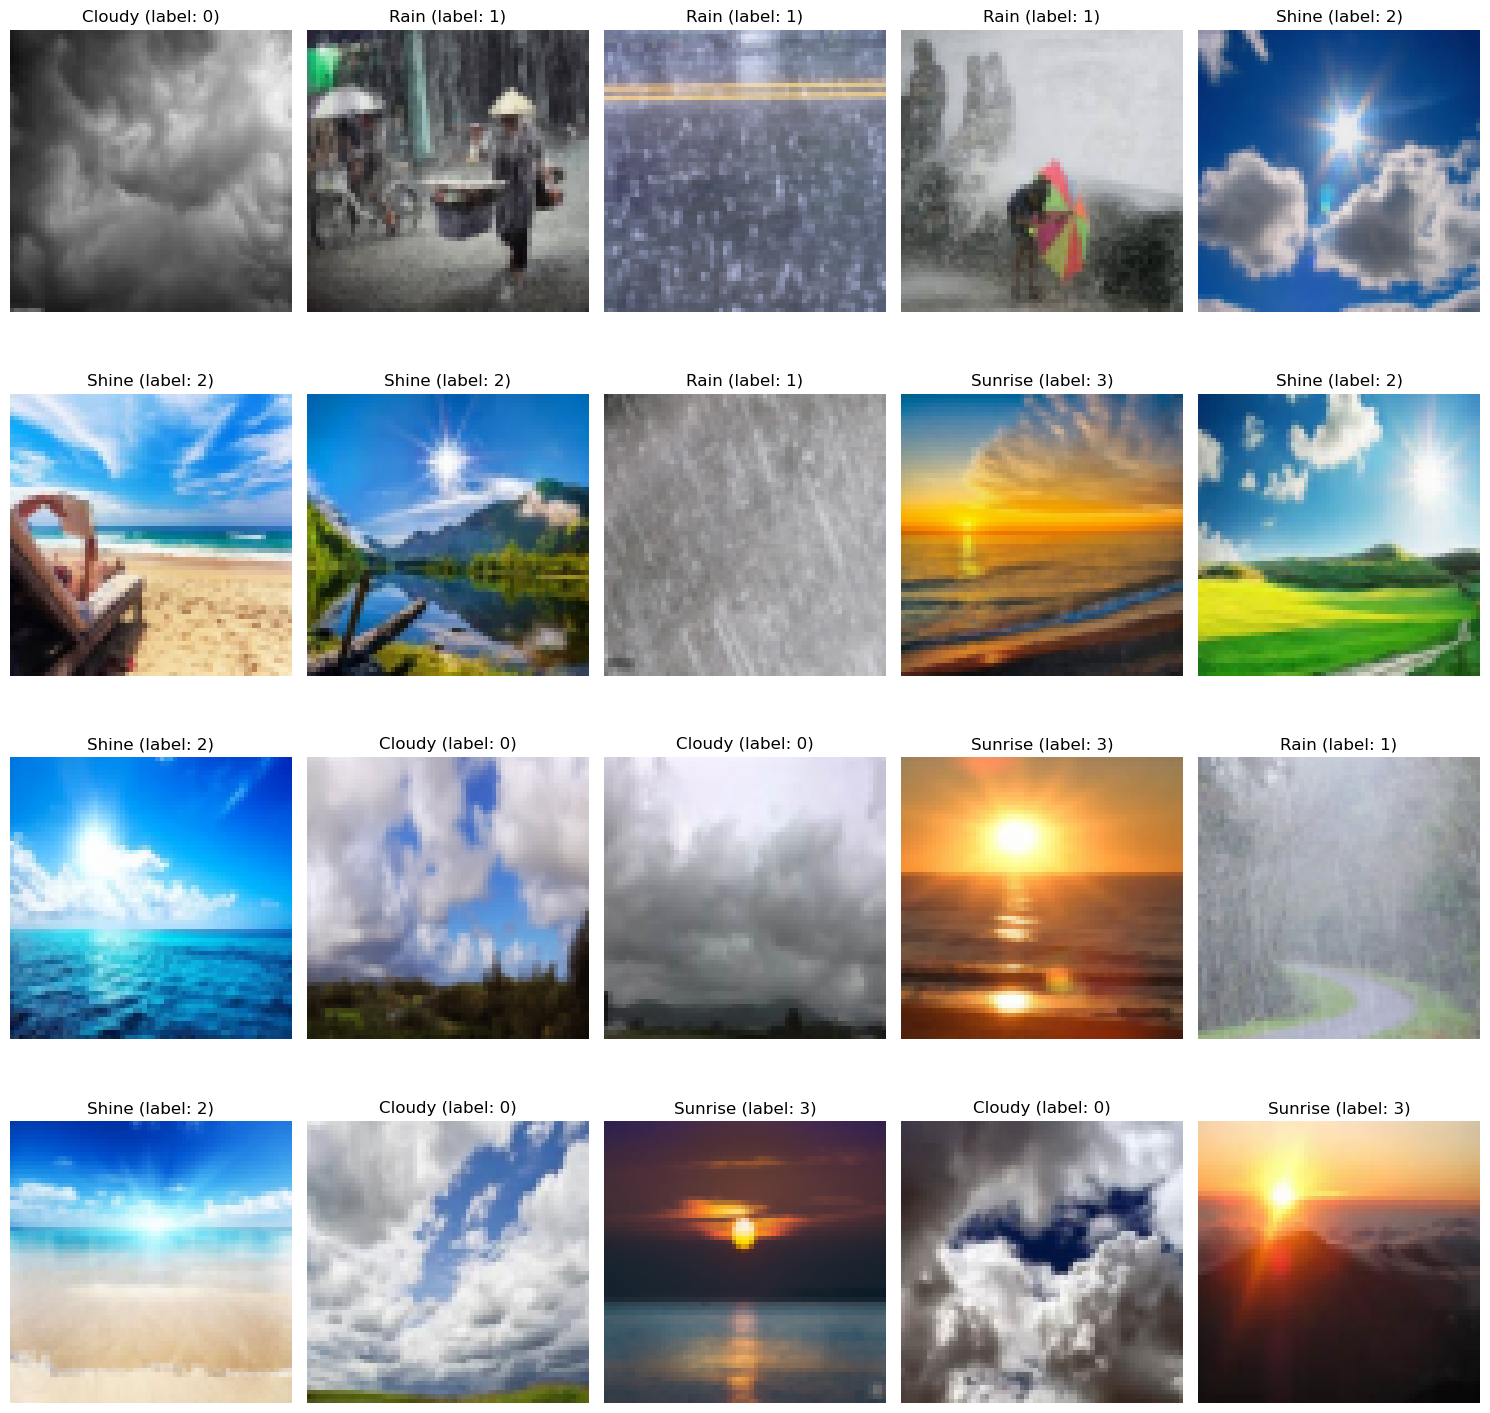

In [6]:
random_indices = np.random.choice(len(images), size=20, replace=False)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"{classes[labels[idx]]} (label: {labels[idx]})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

In [8]:
import numpy as np
from skimage.transform import rotate, rescale, resize
from skimage.exposure import adjust_gamma, adjust_sigmoid
from skimage.color import rgb2hsv, hsv2rgb
from tqdm import tqdm

augmentation_factor = 5

# Function to apply data augmentation on the training set
def augment_images(images, labels, augmentation_factor):
    augmented_images = []
    augmented_labels = []

    for i in tqdm(range(len(images)), desc='Augmenting training images'):
        image = images[i]
        label = labels[i]

        augmented_images.append(image)
        augmented_labels.append(label)

        for _ in range(augmentation_factor):
            augmented_image = image.copy()

            # Horizontal and Vertical Flips
            if np.random.rand() < 0.5:
                augmented_image = np.fliplr(augmented_image)
            if np.random.rand() < 0.5:
                augmented_image = np.flipud(augmented_image)

            # Brightness and Contrast Adjustments
            augmented_image = adjust_gamma(augmented_image, gamma=np.random.uniform(0.7, 1.3))
            augmented_image = adjust_sigmoid(augmented_image, cutoff=np.random.uniform(0.3, 0.7))

            hsv_image = rgb2hsv(augmented_image)
            hsv_image[:, :, 0] += np.random.uniform(-0.05, 0.05)  # Hue variation
            hsv_image[:, :, 1] *= np.random.uniform(0.8, 1.2)      # Saturation variation
            augmented_image = hsv2rgb(hsv_image)

            augmented_image = resize(augmented_image, (img_width, img_height))

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

augmented_X_train, augmented_y_train = augment_images(X_train, y_train, augmentation_factor)

final_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
final_y_train = np.concatenate((y_train, augmented_y_train), axis=0)

print("Augmentation completed")

Augmenting training images: 100%|██████████| 901/901 [00:23<00:00, 38.17it/s]


Augmentation completed


In [9]:
print(X_train.shape)
print(final_X_train.shape)
print(y_train.shape)
print(final_y_train.shape)

(901, 64, 64, 3)
(6307, 64, 64, 3)
(901,)
(6307,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

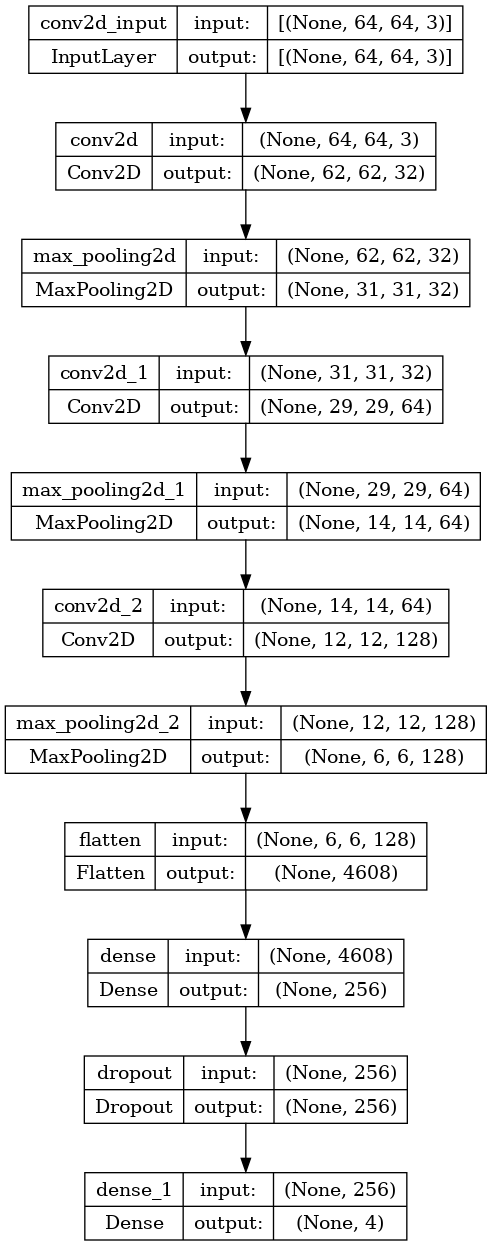

In [10]:
# model architecture - basic CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])



# model arhcitecture summary and plot (graphviz is needed to be installed for plot_model to work)
model.summary()
plot_model(model, show_shapes=True)

In [11]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU Found")

Default GPU Device: /device:GPU:0


In [12]:
# hyperparameters for training
epochs = 50
batch_size = 100
# callback for early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [13]:
# Training the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(final_X_train, final_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])
print("Training completed")

Epoch 1/50
51/51 [==============================] - 13s 33ms/step - loss: 0.7893 - accuracy: 0.6543 - val_loss: 0.5520 - val_accuracy: 0.8098
Epoch 2/50
51/51 [==============================] - 1s 16ms/step - loss: 0.5086 - accuracy: 0.8105 - val_loss: 0.4344 - val_accuracy: 0.8590
Epoch 3/50
51/51 [==============================] - 1s 16ms/step - loss: 0.3952 - accuracy: 0.8557 - val_loss: 0.3871 - val_accuracy: 0.8463
Epoch 4/50
51/51 [==============================] - 1s 18ms/step - loss: 0.3237 - accuracy: 0.8793 - val_loss: 0.3387 - val_accuracy: 0.8796
Epoch 5/50
51/51 [==============================] - 1s 20ms/step - loss: 0.2725 - accuracy: 0.9009 - val_loss: 0.2961 - val_accuracy: 0.8914
Epoch 6/50
51/51 [==============================] - 1s 16ms/step - loss: 0.2224 - accuracy: 0.9205 - val_loss: 0.3108 - val_accuracy: 0.8938
Epoch 7/50
51/51 [==============================] - 1s 15ms/step - loss: 0.2390 - accuracy: 0.9150 - val_loss: 0.3581 - val_accuracy: 0.8693
Epoch 8/50
5

In [14]:
# Model evaluation on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

y_score = model.predict(X_test)
print("Testing completed")

8/8 [==============================] - 0s 17ms/step - loss: 0.1481 - accuracy: 0.9425
Test accuracy: 0.9425
8/8 [==============================] - 0s 3ms/step
Testing completed


In [15]:
# Define needed variables for plotting
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

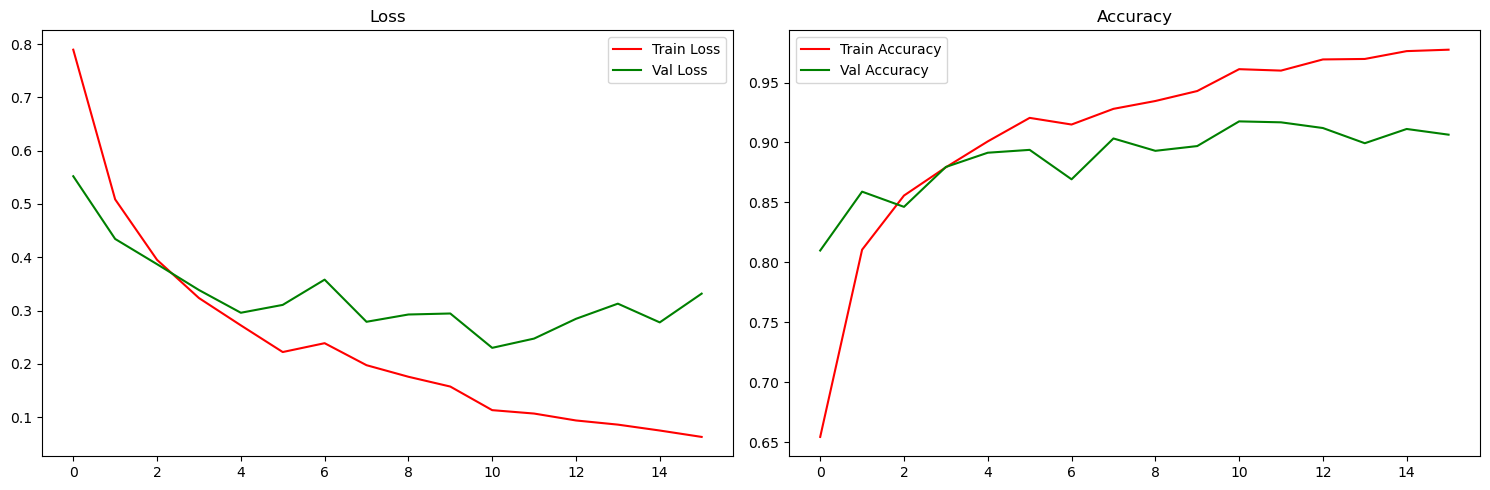

In [16]:
# model loss and accuracy plots
plt.figure(figsize=(15, 5))
plt.style.use('default')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label = 'Train Loss')
plt.plot(history.history['val_loss'][:epochs], 'g', label = 'Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'][:epochs], 'g', label = 'Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

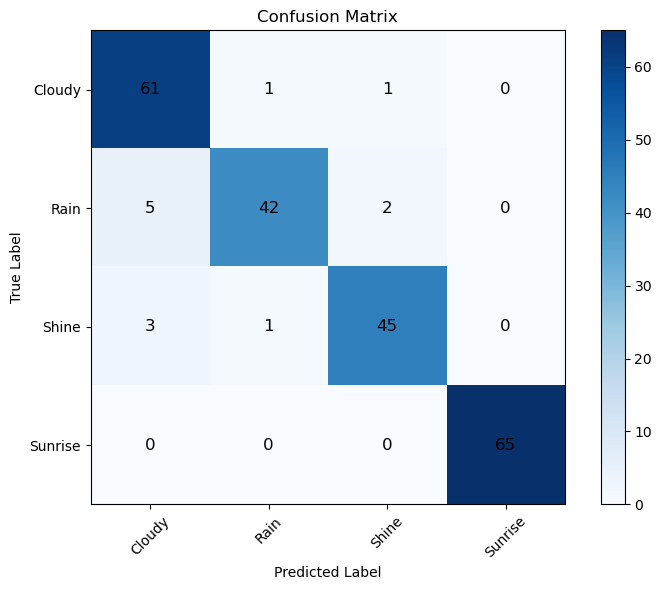

In [17]:
# Get the final confusion matrix 
predicted_labels = np.argmax(y_score, axis=1)
conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

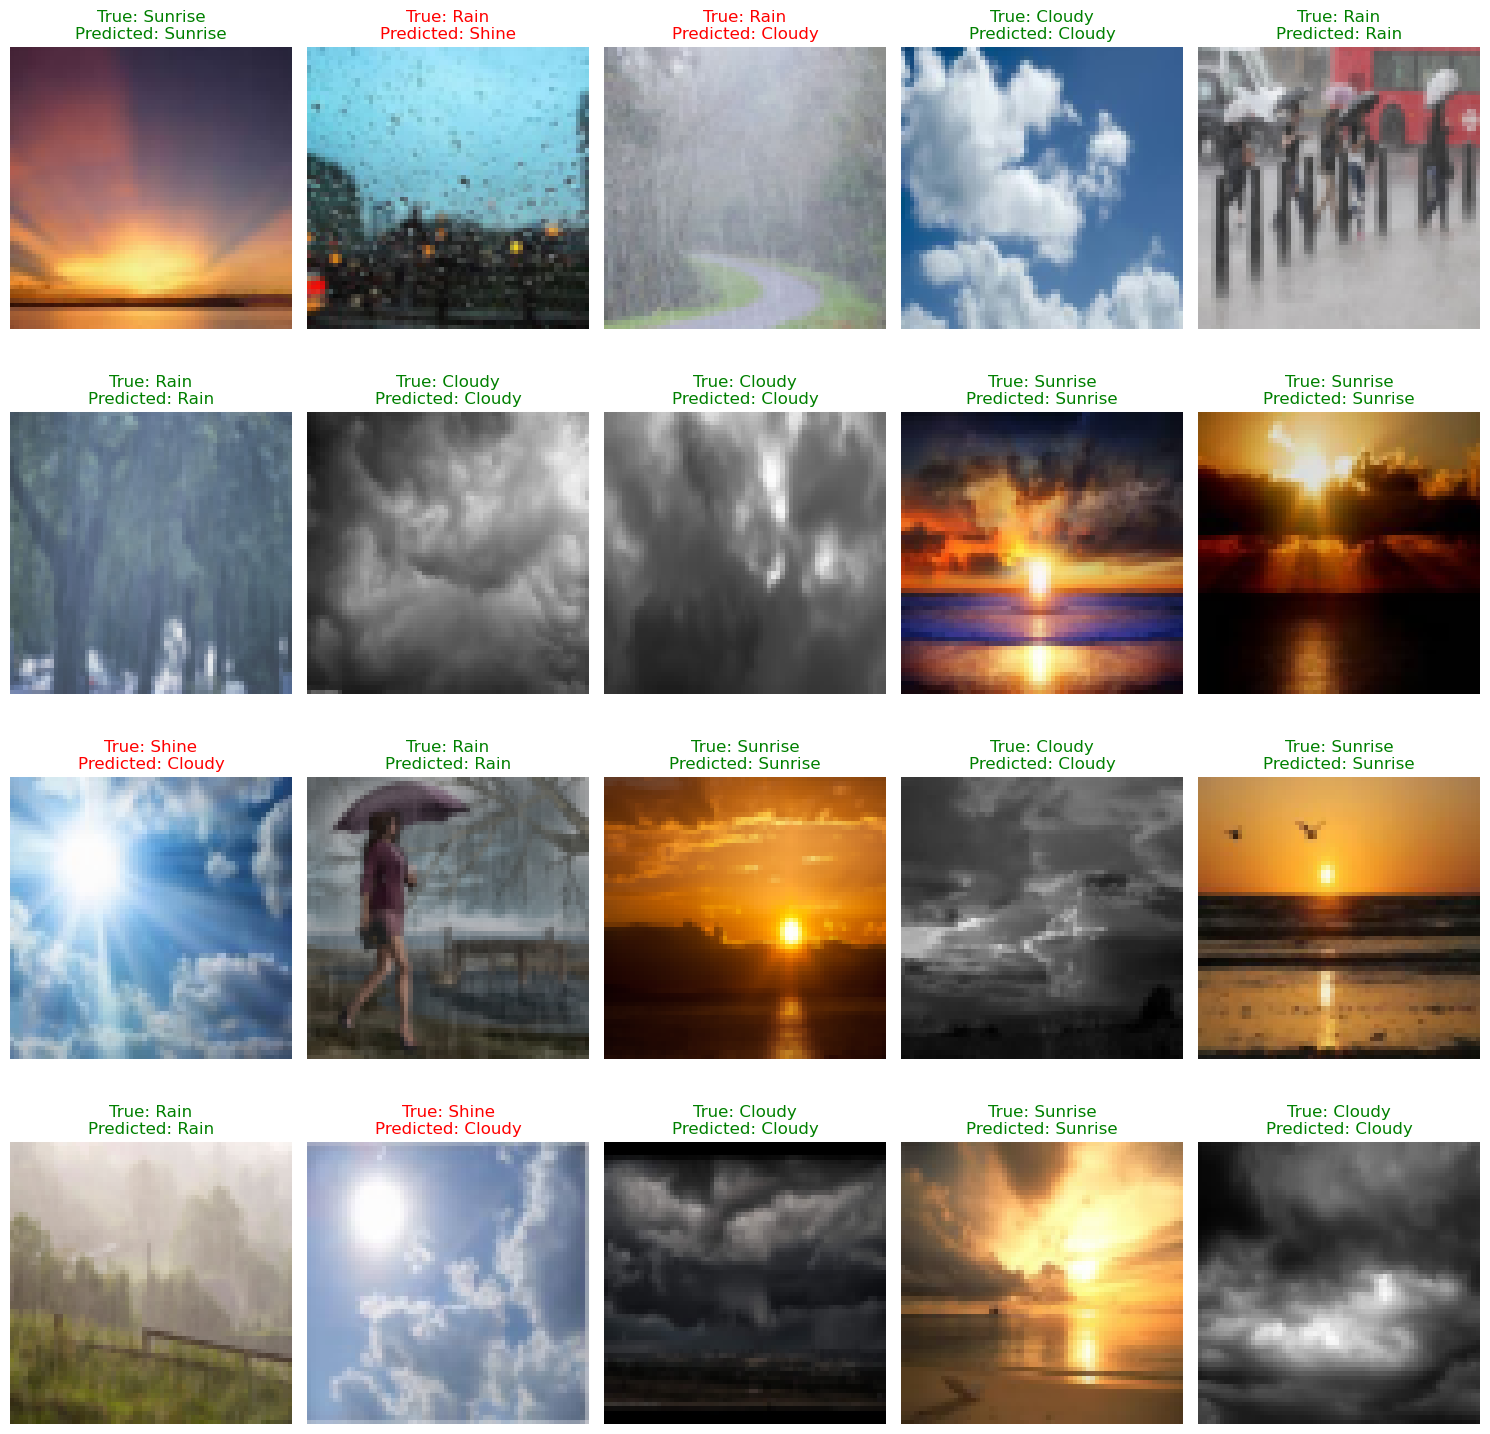

In [18]:
# Plot the test images with correct and predicted labels
num_samples = 20
rows = 4
wrong_predictions_indices = [idx for idx, (true_label, predicted_label) in enumerate(zip(y_test, predicted_labels)) 
                             if true_label != predicted_label]

random_indices = random.sample(range(len(X_test)), num_samples - rows)
random_wrong_indices = random.sample(wrong_predictions_indices, 4)
random_indices.extend(random_wrong_indices)
random_indices = sorted(random_indices)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(rows, int(num_samples / rows), i + 1)
    plt.imshow(X_test[idx])
    true_label = y_test[idx]
    true_class = classes[true_label]
    predicted_class = classes[predicted_labels[idx]]
    
    # color-code the correct predictions 
    if true_class == predicted_class:
        predicted_color = 'green'
    else:
        predicted_color = 'red'
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}', color=predicted_color)
    plt.axis('off')

plt.tight_layout()
plt.show()